In [1]:
# import standards
import pandas as pd
import numpy as np
import re

# import visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker

# import data tools
from imblearn.over_sampling import SMOTE

# other
from prepare import collision_data
from explore import ttest_report, chi_test, gridsearch, get_rfe_selected, classifier_scores
from matplotlib.style import use; use('~/.matplotlib/gruvbox.mplstyle')

In [2]:
train, test = collision_data()
img = mpimg.imread('sa.png')
# create mask for injury
injured = train.injury_class == 1

## Time

In [3]:
# create counts of vehicles with injuries reported grouped by hours
hourly_injured = train[train.injury_class == 1].set_index('crash_date').resample('H').count().crash_id
# create counts of vehicles with injuries reported grouped by hours
hourly_uninjured = train[train.injury_class == 0].set_index('crash_date').resample('H').count().crash_id
# set upper bound for injuries reported
q1, q3 = hourly_injured.quantile([0.25, 0.75])
iqr = q3 - q1
excess_injured = iqr + 1.5 * q3

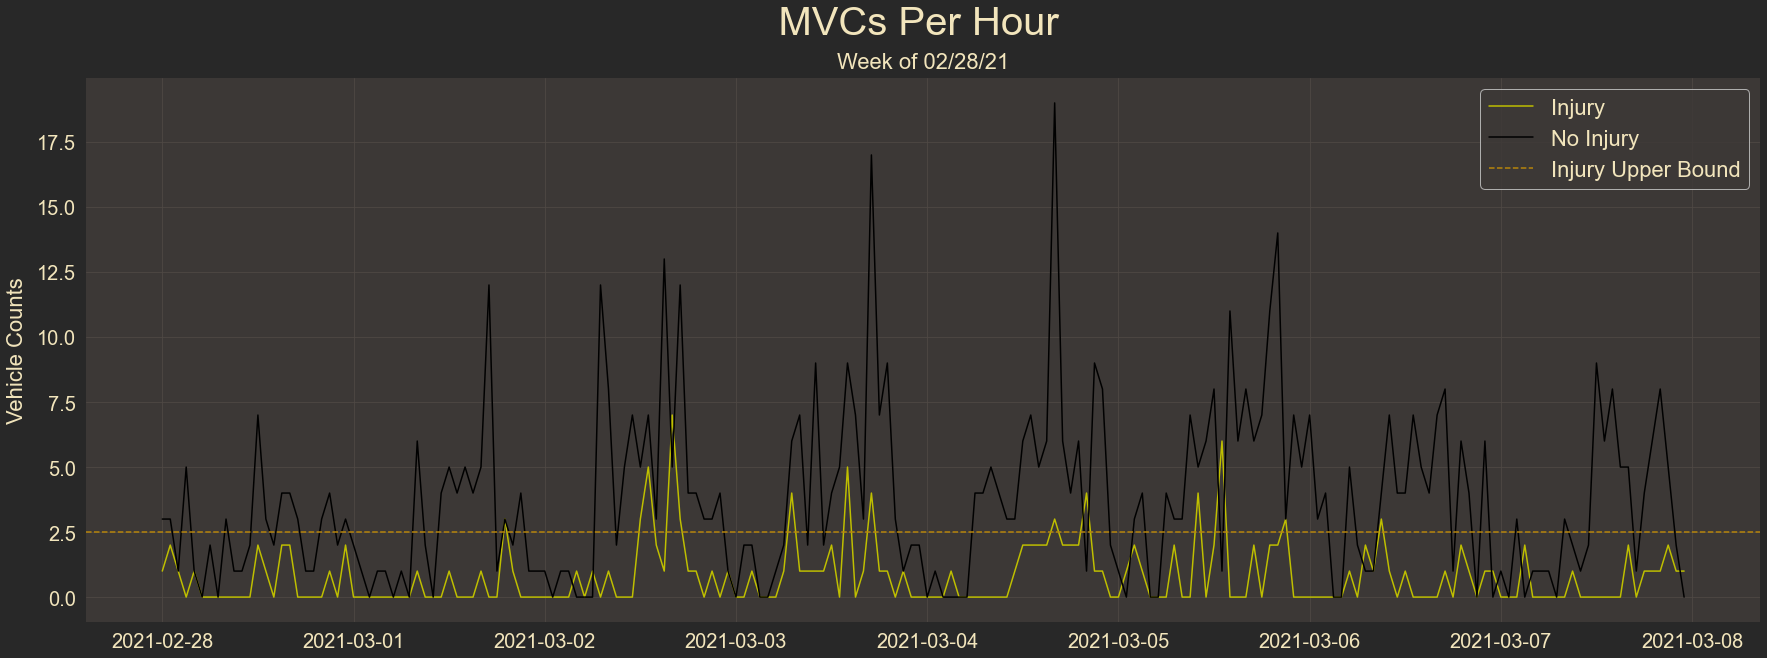

In [4]:
# set ax
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(hourly_injured['2021-02-28':'2021-03-07'], c='y', label='Injury')
ax.plot(hourly_uninjured['2021-02-28':'2021-03-07'], c='k', label='No Injury')
ax.axhline(excess_injured, c='darkgoldenrod', linestyle='dashed', label='Injury Upper Bound')
ax.tick_params(labelsize=20, pad=10)
ax.set_ylabel('Vehicle Counts', fontsize=22, labelpad=10)
plt.suptitle('    MVCs Per Hour', fontsize=40)
plt.title('Week of 02/28/21', fontsize=22, pad=10)
plt.legend(fontsize=22, frameon=True)
plt.show()

In [5]:
train['day_num'] = train.set_index('crash_date').index.day_of_week

In [6]:
crash_hour_mean = train.groupby(['day_num', 'crash_hour']).mean().injury_class
q1, q3 = crash_hour_mean.quantile([0.25, 0.75])
iqr = q3 - q1
upper = iqr + 1.5 * q3

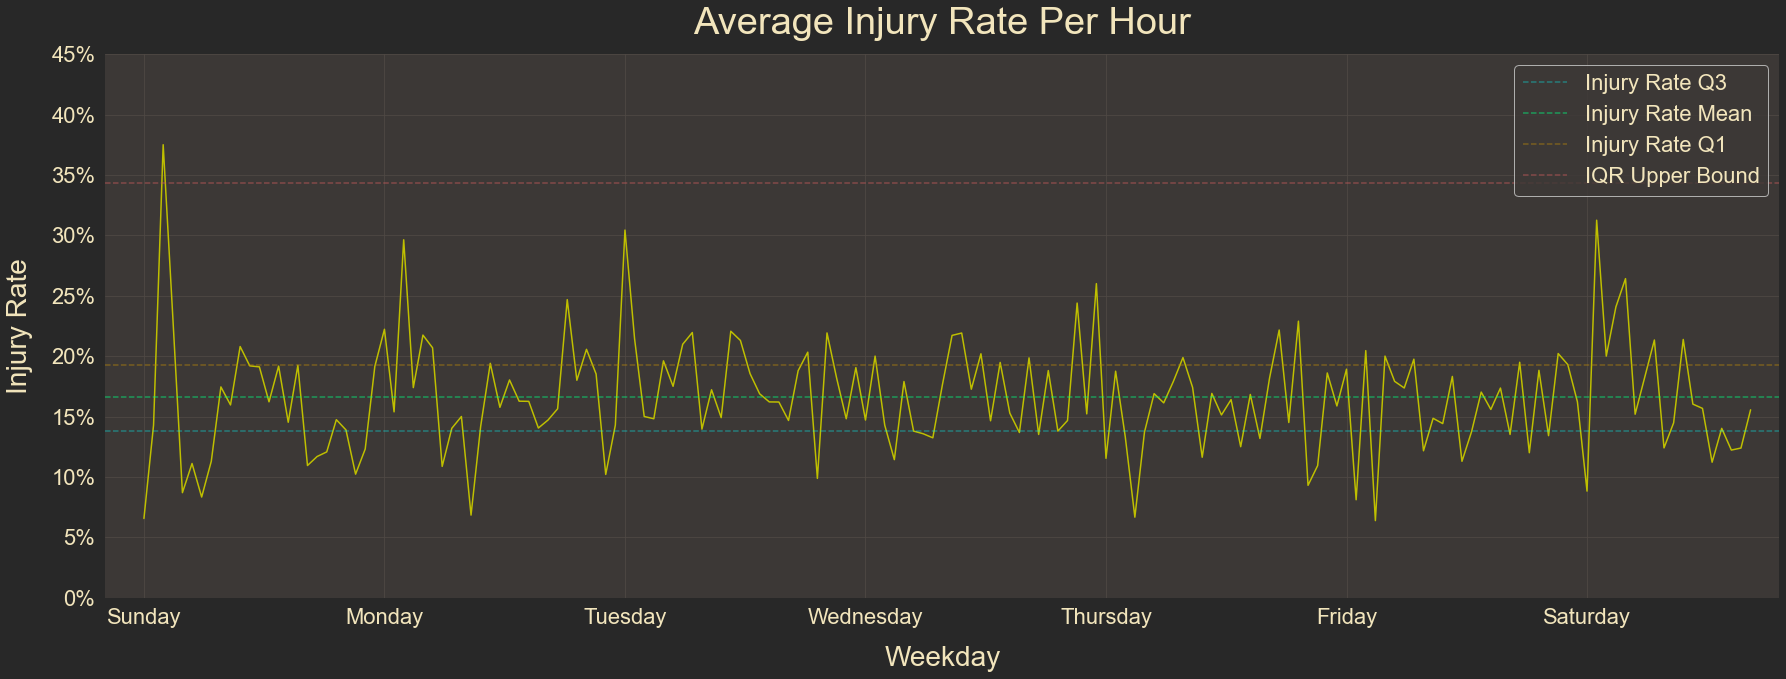

In [38]:
# create figure and set dimensions
fig, ax = plt.subplots(figsize=(30,10))
# plot average injuries per hour
crash_hour_mean.plot(ax=ax, c='y', label='')
# plot q1, mean, q3, and iqr upper for injuries
ax.axhline(q1, linestyle='dashed', c='cyan', alpha=0.35, label='Injury Rate Q3')
ax.axhline(crash_hour_mean.mean(), linestyle='dashed', c='springgreen', alpha=0.5, label='Injury Rate Mean')
ax.axhline(q3, linestyle='dashed', c='darkgoldenrod', alpha=0.5, label='Injury Rate Q1')
ax.axhline(upper, linestyle='dashed', c='indianred', alpha=0.5, label='IQR Upper Bound')
# set axis labels
ax.set_xlabel('Weekday', fontsize=28, labelpad=18)
ax.set_ylabel('Injury Rate', fontsize=28, labelpad=18)
# define tick params and labels
ax.tick_params(labelsize=22, pad=10)
ax.set_xticklabels(['', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', '', ''])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
# set limits for formatting
ax.set_xlim(xmin=-4, xmax=170)
ax.set_ylim(ymin=0, ymax=.45)
# define appropraite legend params and title
ax.legend(fontsize=22, frameon=True, loc='upper right')
plt.title('Average Injury Rate Per Hour', fontsize=38, pad=20)
# print it
plt.show()

In [91]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['crash_day', 'crash_hour']).crash_id.count() /
                    train.groupby(['crash_day', 'crash_hour']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['crash_day', 'crash_hour']).crash_id.count() /
                    train.groupby(['crash_day', 'crash_hour']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

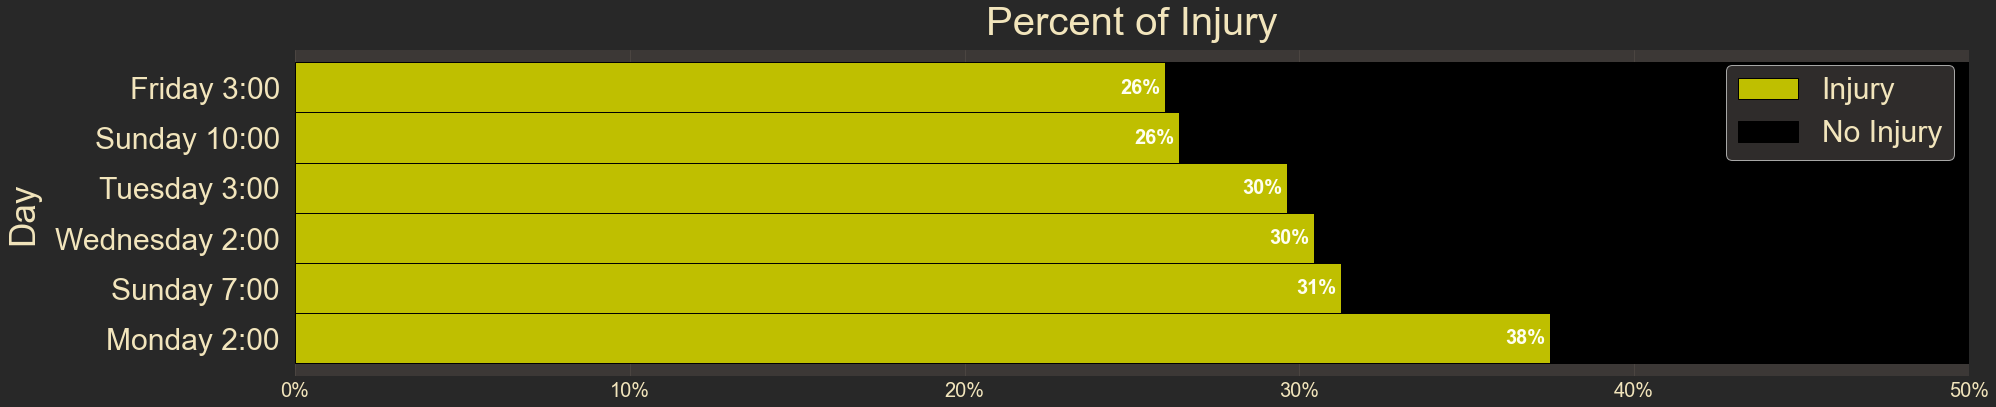

In [99]:
# set ax
fig, ax = plt.subplots(figsize=(30,6))
# create barplot
bars = injury_pct_df[injury_pct_df.pct_inj > 0.25].sort_values('pct_inj', ascending=False).plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:6]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\'\((\w+),\s(\d+).+', r'\1 \2:00', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.5)
# remove unneeded lavel
ax.set_ylabel('Day', size=35, labelpad=15)
# define legend
ax.legend(labels=['Injury', 'No Injury'], fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

In [86]:
train['crash_day_hour'] = train.apply(lambda row: str(row.crash_day) + str(row.crash_hour), axis=1)

In [96]:
chi_test(train.crash_day_hour, train.injury_class)


    alpha: 0.05
    p-value: 0.03

    Due to p-value 0.03 being less than significance level 0.05, may reject the null hypothesis that "injury_class" is independent of "crash_day_hour."
    


**Visual Takeaways**

- Monday, Tuesday, Saturday early evening shows a decrease to injury rate before a sudden upward trend into the early hours of the following day
- Wednesday, Thursday seem to be more consistently near the mean rate versus other days
- Sunday early morning has the highest rate of traffic injuries throughout the data

## Time Breakdowns

#### Hourly

In [89]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['crash_hour']).crash_id.count() /
                    train.groupby(['crash_hour']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['crash_hour']).crash_id.count() /
                    train.groupby(['crash_hour']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

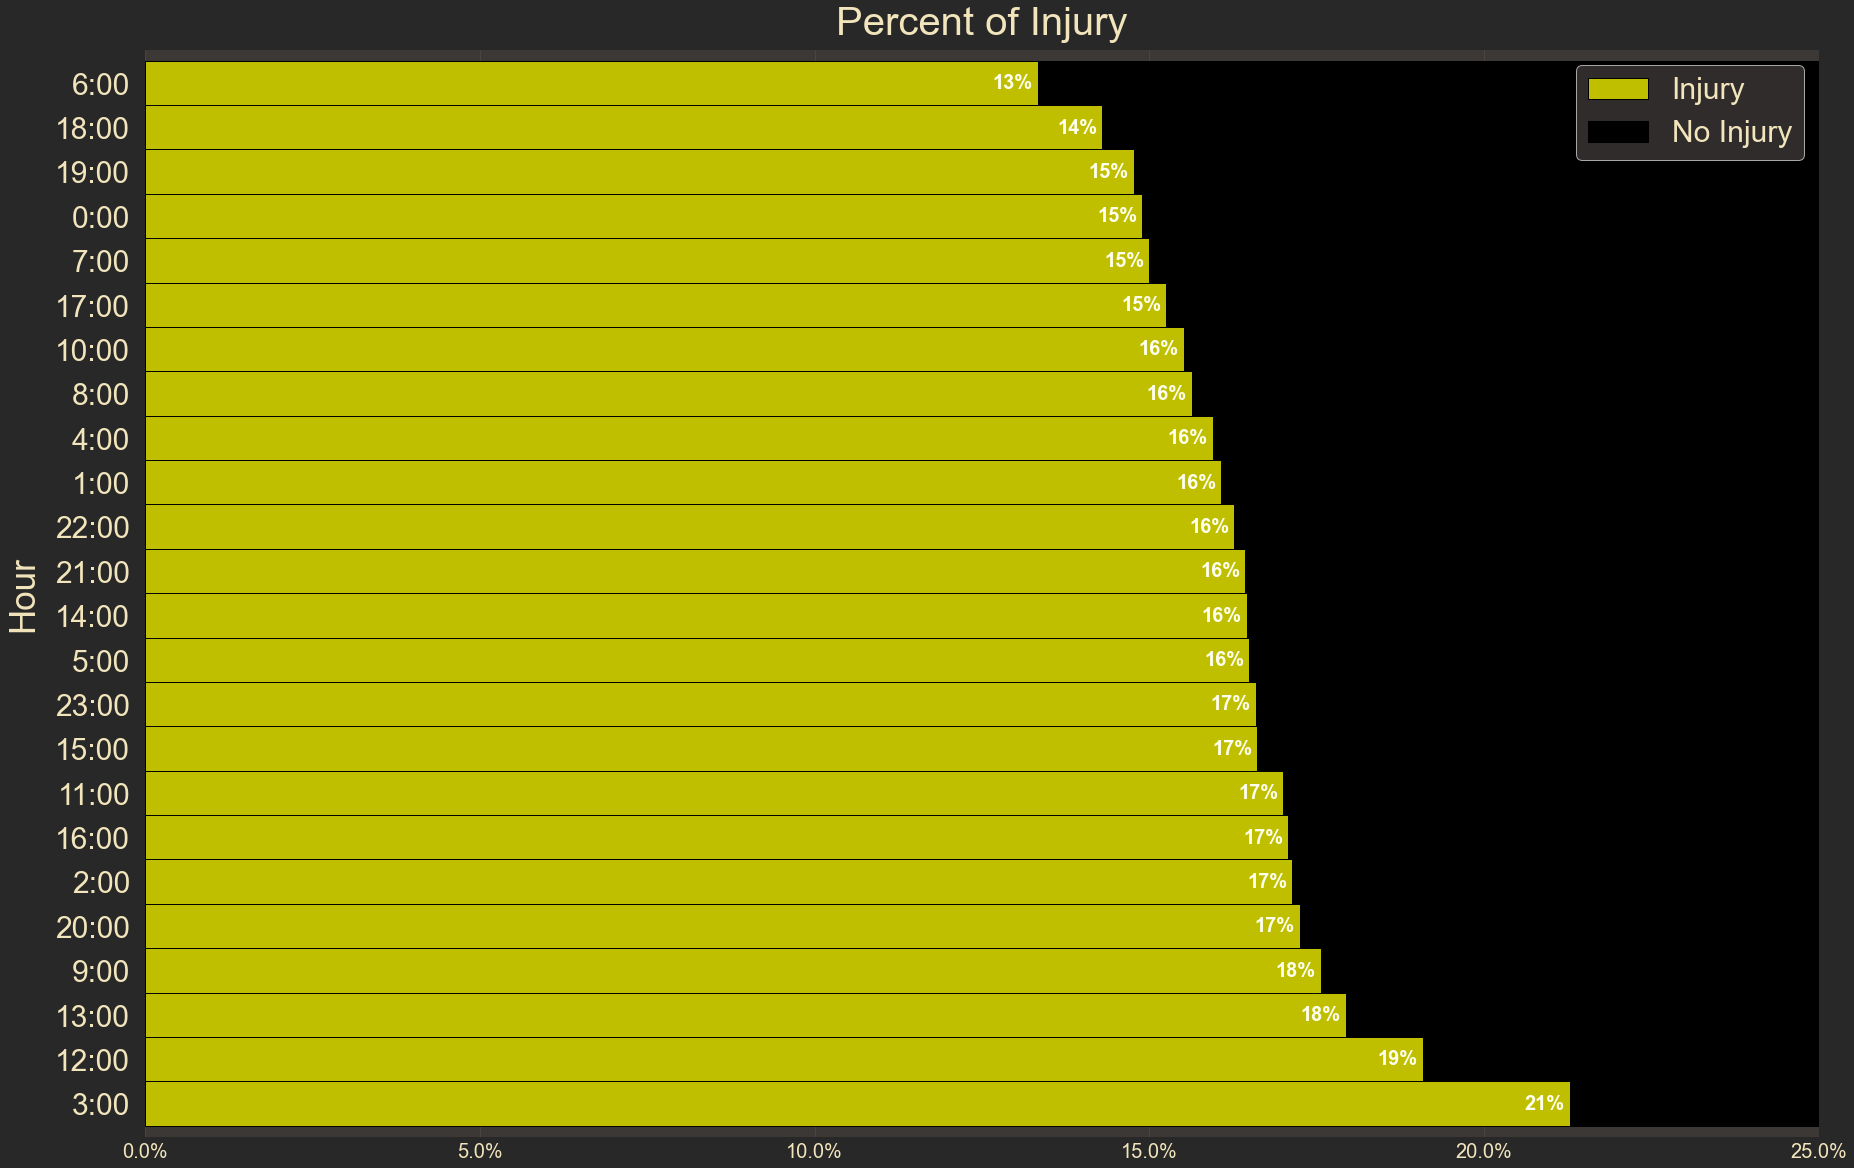

In [90]:
# set ax
fig, ax = plt.subplots(figsize=(30,20))
# create barplot
bars = injury_pct_df.sort_values('pct_inj', ascending=False).plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:24]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'\D+\d,\s\d{1,2}\D+(\d{1,2}).+', r'\1:00', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('Hour', size=35, labelpad=15)
# define legend
ax.legend(labels=['Injury', 'No Injury'], fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

**Hypothesis Testing**

H$_{0}$: The hour of the MVC is independent of whether an injury occurs or not.

In [10]:
chi_test(train.crash_hour, train.injury_class)


    alpha: 0.05
    p-value: 0.1

    Due to p-value 0.1 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "crash_hour."
    


**Takeaways**

In the visual percentages of hour of accident with injury percentages, there is a marked increased in 0300 hours to 21%. Using $x^2$ testing, there is shown to be a statistical difference in the to categories of hour and if injury occurs.

#### Day of Week

In [11]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['crash_day']).crash_id.count() /
                    train.groupby(['crash_day']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['crash_day']).crash_id.count() /
                    train.groupby(['crash_day']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

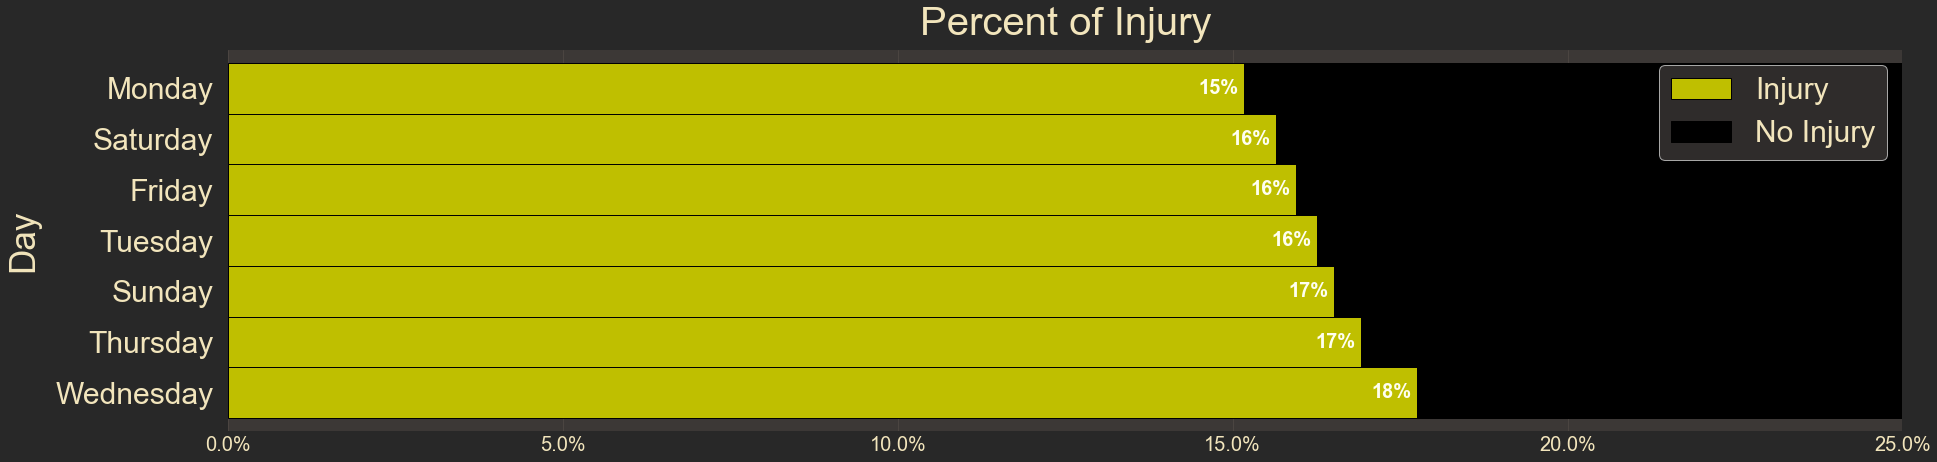

In [12]:
# set ax
fig, ax = plt.subplots(figsize=(30,7))
# create barplot
bars = injury_pct_df.sort_values('pct_inj', ascending=False).plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:7]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\'(\w+).+', r'\1', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('Day', size=35, labelpad=15)
# define legend
ax.legend(labels=['Injury', 'No Injury'], fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

**Hypothesis Testing**

H$_{0}$: The day of the week is independent of whether or not injury occurs as result of an MVC.

In [95]:
chi_test(train.crash_day, train.injury_class)


    alpha: 0.05
    p-value: 0.1

    Due to p-value 0.1 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "crash_day."
    


**Takeaways**

Despite the visual percentage of injuries across days of the week showing increased rates on certain days over others, the statistical testing failed to reject the null hypothesis of independence between the two variables.

## Events

#### Events: Spurs Home Games

In [14]:
# create list of dates for spurs home games
spurs_games = ['2021-02-01', '2021-02-03', '2021-02-08', '2021-02-09',
               '2021-02-27', '2021-03-01', '2021-03-02', '2021-03-04',
               '2021-03-12', '2021-03-22', '2021-03-24', '2021-03-25',
               '2021-03-27', '2021-03-29', '2021-03-31', '2021-04-01',
               '2021-04-03', '2021-04-05', '2021-04-16', '2021-04-21',
               '2021-04-22', '2021-05-02', '2021-05-10', '2021-05-15',
               '2021-05-16']
# create mask for indexs on spurs game days
train['spurs'] = train.apply(lambda row: True if any(date in str(row.crash_date) for date in spurs_games) and row.crash_hour > 14 else False, axis=1)

In [15]:
# set central points of AT&T center geocoords
att_lat = 29.426944
att_lon = -98.4375
# create maks for filtering location to nearby AT&T center
att_lat_1 = ((train.crash_latitude > att_lat * 0.999) &
              (train.crash_latitude < att_lat * 1.001))
att_lon_1 = ((train.crash_longitude > att_lon * 1.0005) &
              (train.crash_longitude < att_lon * 0.9995))
train['att_1'] = att_lat_1 & att_lon_1
# create maks for filtering location to slighty outside AT&T center
att_lat_2 = ((train.crash_latitude > att_lat * 0.998) &
              (train.crash_latitude < att_lat * 1.002) &
              ~(att_lat_1 & att_lon_1))
att_lon_2 = ((train.crash_longitude > att_lon * 1.0009) &
              (train.crash_longitude < att_lon * 0.9991) &
              ~(att_lat_1 & att_lon_1))
train['att_2'] = att_lat_2 & att_lon_2


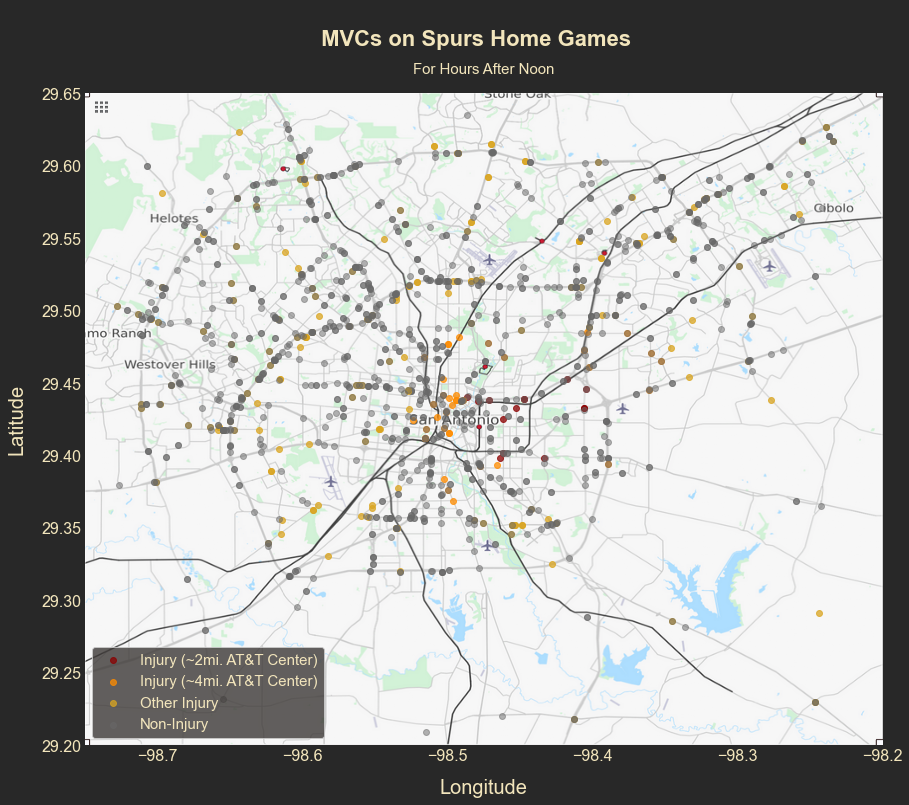

In [16]:
fig, ax = plt.subplots(figsize=(15,12))
ax.imshow(img, origin='upper', extent=(-98.75, -98.2, 29.2, 29.65))
ax.scatter(train[train.spurs & train.att_1 & injured].crash_longitude,
            train[train.spurs & train.att_1 & injured].crash_latitude,
            c='darkred', alpha=0.75, label='Injury (~2mi. AT&T Center)')
ax.scatter(train[train.spurs & train.att_1 & ~injured].crash_longitude,
            train[train.spurs & train.att_1 & ~injured].crash_latitude,
            c='dimgray', alpha=0.5)
ax.scatter(train[train.spurs & train.att_2 & injured].crash_longitude,
            train[train.spurs & train.att_2 & injured].crash_latitude,
            c='darkorange', alpha=0.75, label='Injury (~4mi. AT&T Center)')
ax.scatter(train[train.spurs & train.att_2 & ~injured].crash_longitude,
            train[train.spurs & train.att_2 & ~injured].crash_latitude,
            c='dimgray', alpha=0.5)
ax.scatter(train[train.spurs & ~(train.att_1) & ~(train.att_2) & injured].crash_longitude,
            train[train.spurs & ~(train.att_1) & ~(train.att_2) & injured].crash_latitude,
            c='goldenrod', alpha=0.75, label='Other Injury')
ax.scatter(train[train.spurs & ~(train.att_1) & ~(train.att_2) & ~injured].crash_longitude,
            train[train.spurs & ~(train.att_1) & ~(train.att_2) & ~injured].crash_latitude,
            c='dimgray', alpha=0.5, label='Non-Injury')

plt.xlabel('Longitude', fontsize=20, labelpad=15)
plt.ylabel('Latitude', fontsize=20, labelpad=15)
plt.xlim((-98.75, -98.2))
plt.ylim((29.2, 29.65))
plt.grid()
plt.legend(fontsize=15, frameon=True)
plt.suptitle('\n  MVCs on Spurs Home Games', size=22, weight='bold')
plt.title('For Hours After Noon', fontsize=15, pad=20)
plt.show()

In [17]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['spurs']).crash_id.count() /
                    train.groupby(['spurs']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['spurs']).crash_id.count() /
                    train.groupby(['spurs']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)

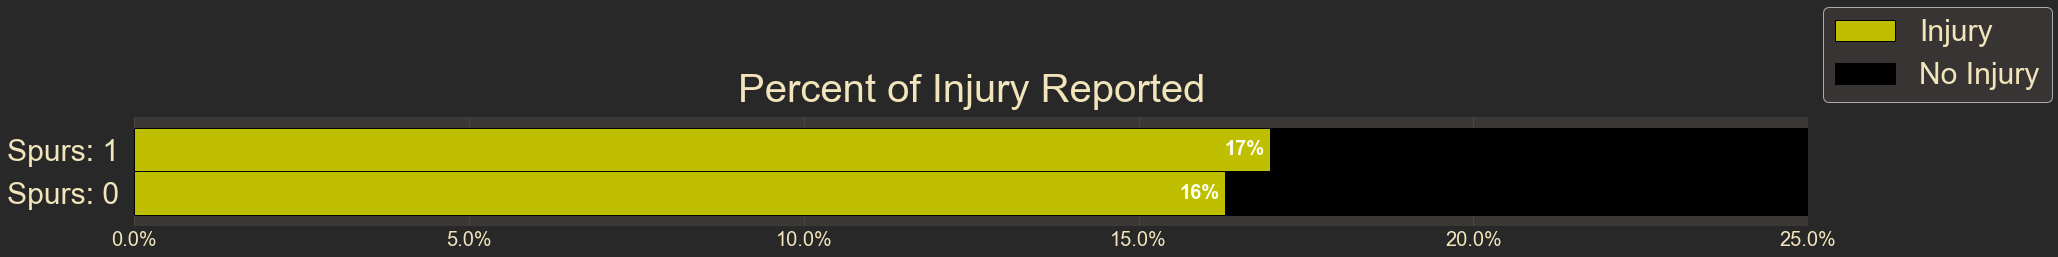

In [18]:
# set ax
fig, ax = plt.subplots(figsize=(30,2))
# create barplot
bars = injury_pct_df.plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:2]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'\D+\d\D+(\d)\D+', r'Spurs: \1', str(x)) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury Reported', fontsize=40, pad=15)
# make it rain
plt.show()

**Hypothesis Testing**

H$_{0}$: Injury occuring as a result of MVCs is independent of of being near the AT&T Center on days of Spurs Home Games.

In [19]:
chi_test(train[train.spurs].att_1, train[train.spurs].injury_class)


    alpha: 0.05
    p-value: 1

    Due to p-value 1 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "att_1."
    


In [20]:
chi_test(train[train.spurs].att_2, train[train.spurs].injury_class)


    alpha: 0.05
    p-value: 0.9

    Due to p-value 0.9 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "att_2."
    


In [21]:
chi_test(train.spurs, train.injury_class)


    alpha: 0.05
    p-value: 0.5

    Due to p-value 0.5 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "spurs."
    


In [22]:
chi_test(train[train.spurs].fault_intoxication, train[train.spurs].injury_class)


    alpha: 0.05
    p-value: 0.2

    Due to p-value 0.2 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "fault_intoxication."
    


#### Events: Fiesta

In [25]:
# create mask for dates between fiesta
train['fiesta'] = train.crash_date.between('2021-06-17', '2021-06-27')

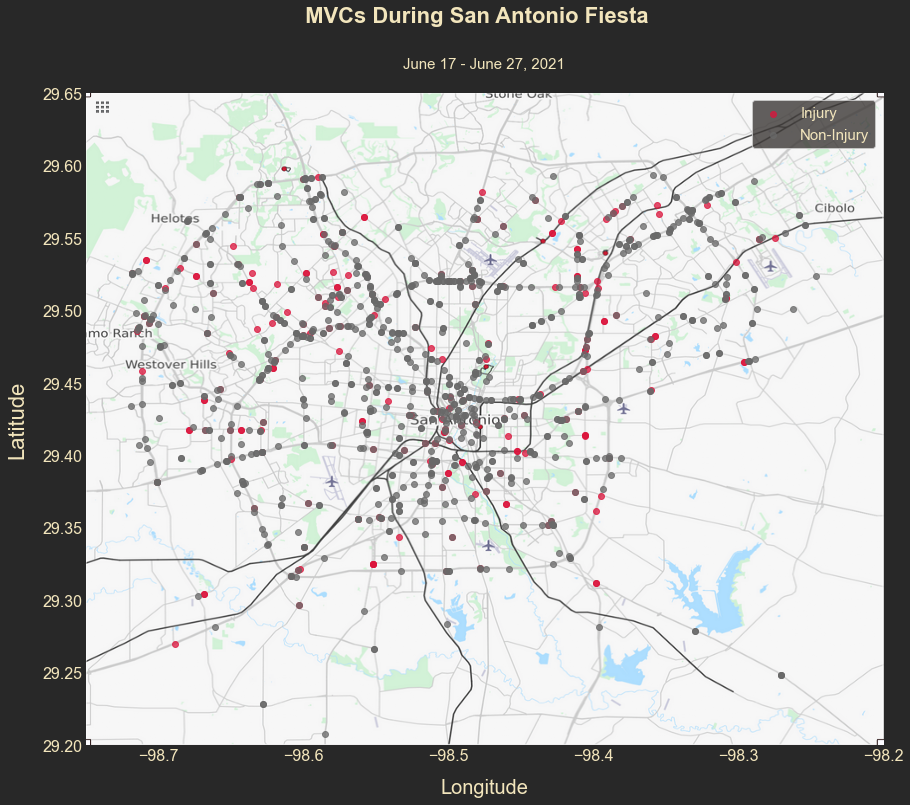

In [26]:
fig, ax = plt.subplots(figsize=(15,12))
ax.imshow(img, origin='upper',
          extent=(-98.75, -98.2, 29.2, 29.65))
plt.scatter(train[train.fiesta & injured].crash_longitude,
            train[train.fiesta & injured].crash_latitude,
            c='crimson', alpha=0.75, label='Injury')
plt.scatter(train[train.fiesta & ~injured].crash_longitude,
            train[train.fiesta & ~injured].crash_latitude,
            c='dimgray', alpha=0.75, label='Non-Injury')
plt.xlabel('Longitude', fontsize=20, labelpad=15)
plt.ylabel('Latitude', fontsize=22, labelpad=15)
plt.xlim((-98.75, -98.2))
plt.ylim((29.2, 29.65))
plt.grid()
plt.legend(fontsize=15, frameon=True)
plt.suptitle('  MVCs During San Antonio Fiesta', size=22, weight='bold')
plt.title('June 17 - June 27, 2021', fontsize=15, pad=25)
plt.show()

In [27]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['fiesta']).crash_id.count() /
                    train.groupby(['fiesta']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['fiesta']).crash_id.count() /
                    train.groupby(['fiesta']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)

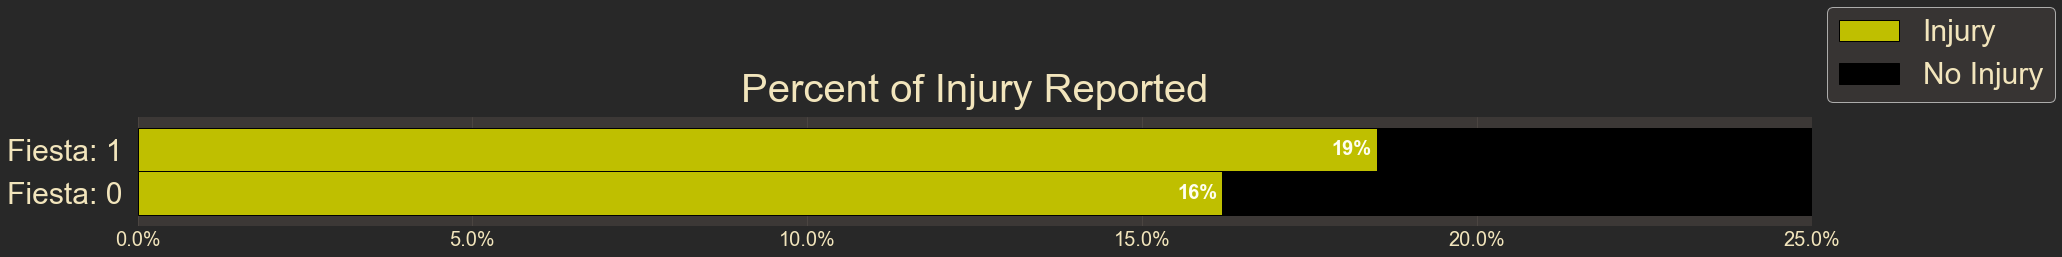

In [28]:
# set ax
fig, ax = plt.subplots(figsize=(30,2))
# create barplot
bars = injury_pct_df.plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:2]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'\D+\d\D+(\d)\D+', r'Fiesta: \1', str(x)) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury Reported', fontsize=40, pad=15)
# make it rain
plt.show()

In [29]:
chi_test(train.fiesta, train.injury_class)


    alpha: 0.05
    p-value: 0.04

    Due to p-value 0.04 being less than significance level 0.05, may reject the null hypothesis that "injury_class" is independent of "fiesta."
    


In [30]:
chi_test(train[train.fault_intoxication ==1].fiesta, train.injury_class)


    alpha: 0.05
    p-value: 0.2

    Due to p-value 0.2 being more than significance level 0.05, fail to reject the null hypothesis that "injury_class" is independent of "fiesta."
    


In [29]:
chi_test(train.fiesta, train.fault_intoxication)


    alpha: 0.05
    p-value: 0.07

    Due to p-value 0.07 being more than significance level 0.05, fail to reject the null hypothesis that "fault_intoxication" is independent of "fiesta."
    


#### Events: July 4 Weekend

In [53]:
# create mask for dates between fiesta
train['jul_fourth'] = train.crash_date.between('2021-07-01', '2021-07-06 09:00:00')

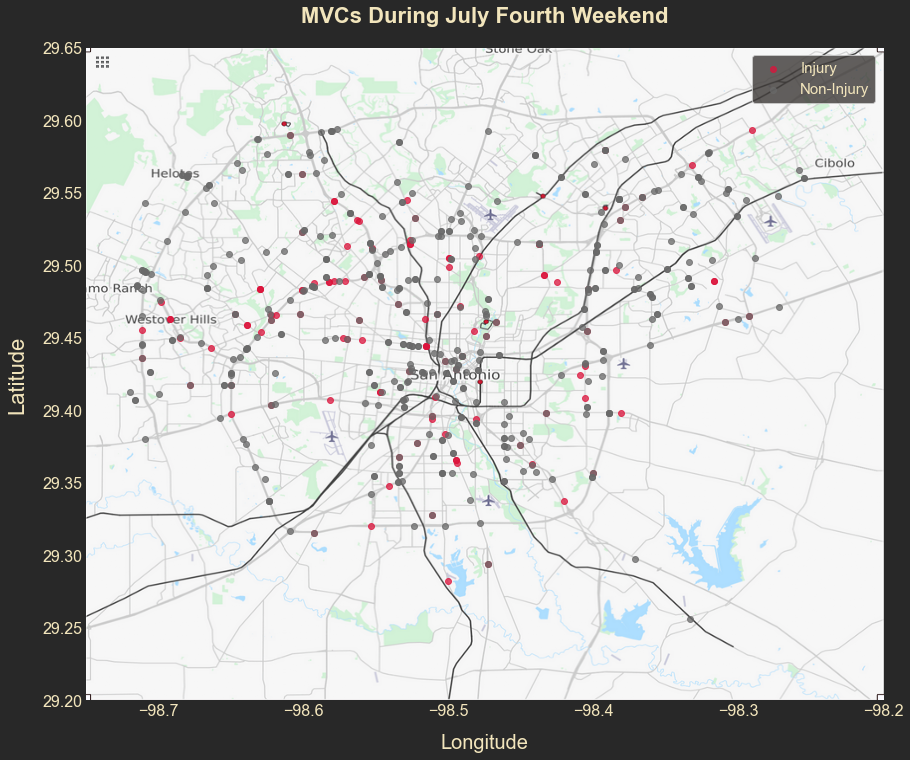

In [54]:
fig, ax = plt.subplots(figsize=(15,12))
ax.imshow(img, origin='upper',
          extent=(-98.75, -98.2, 29.2, 29.65))
plt.scatter(train[train.jul_fourth & injured].crash_longitude,
            train[train.jul_fourth & injured].crash_latitude,
            c='crimson', alpha=0.75, label='Injury')
plt.scatter(train[train.jul_fourth & ~injured].crash_longitude,
            train[train.jul_fourth & ~injured].crash_latitude,
            c='dimgray', alpha=0.75, label='Non-Injury')
plt.xlabel('Longitude', fontsize=20, labelpad=15)
plt.ylabel('Latitude', fontsize=22, labelpad=15)
plt.xlim((-98.75, -98.2))
plt.ylim((29.2, 29.65))
plt.grid()
plt.legend(fontsize=15, frameon=True)
plt.title('MVCs During July Fourth Weekend', fontsize=22, weight='bold', pad=25)
plt.show()

In [55]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['jul_fourth']).crash_id.count() /
                    train.groupby(['jul_fourth']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['jul_fourth']).crash_id.count() /
                    train.groupby(['jul_fourth']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)

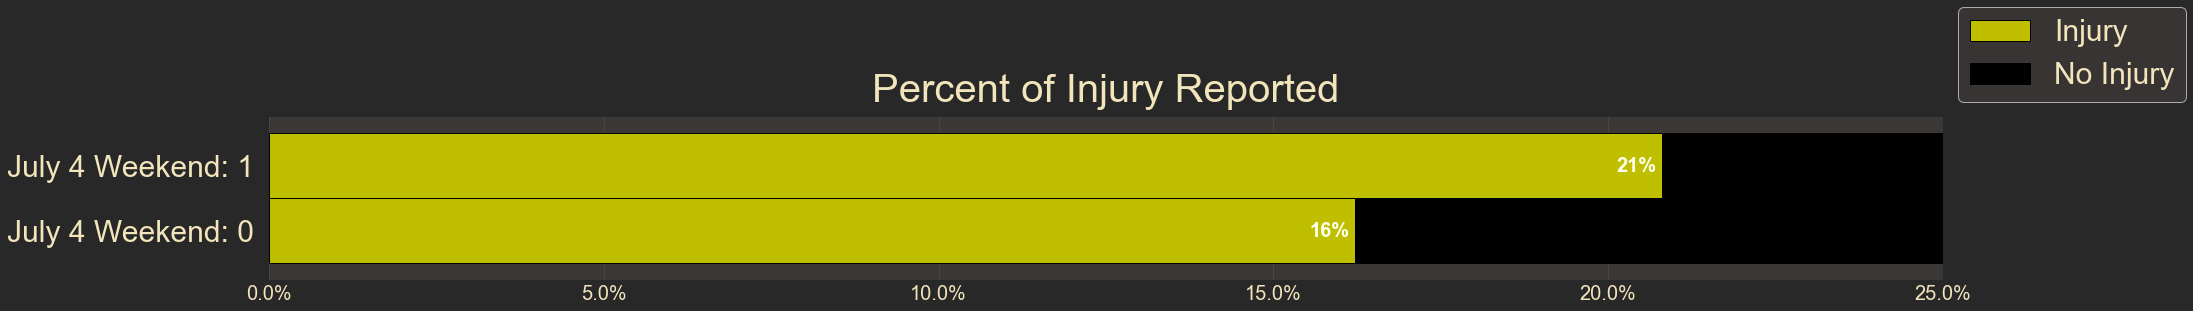

In [56]:
# set ax
fig, ax = plt.subplots(figsize=(30,3))
# create barplot
bars = injury_pct_df.plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:2]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'\D+\d\D+(\d)\D+', r'July 4 Weekend: \1', str(x)) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=0.25)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury Reported', fontsize=40, pad=15)
# make it rain
plt.show()

In [57]:
chi_test(train.jul_fourth, train.injury_class)


    alpha: 0.05
    p-value: 0.005

    Due to p-value 0.005 being less than significance level 0.05, may reject the null hypothesis that "injury_class" is independent of "jul_fourth."
    


In [58]:
chi_test(train.jul_fourth, train.fault_intoxication)


    alpha: 0.05
    p-value: 0.04

    Due to p-value 0.04 being less than significance level 0.05, may reject the null hypothesis that "fault_intoxication" is independent of "jul_fourth."
    


In [59]:
chi_test(train.jul_fourth, train.fault_speed)


    alpha: 0.05
    p-value: 0.4

    Due to p-value 0.4 being more than significance level 0.05, fail to reject the null hypothesis that "fault_speed" is independent of "jul_fourth."
    


---
---

In [30]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['driver_age_bin', 'driver_male']).crash_id.count() /
                    train.groupby(['driver_age_bin', 'driver_male']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['driver_age_bin', 'driver_male']).crash_id.count() /
                    train.groupby(['driver_age_bin', 'driver_male']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)

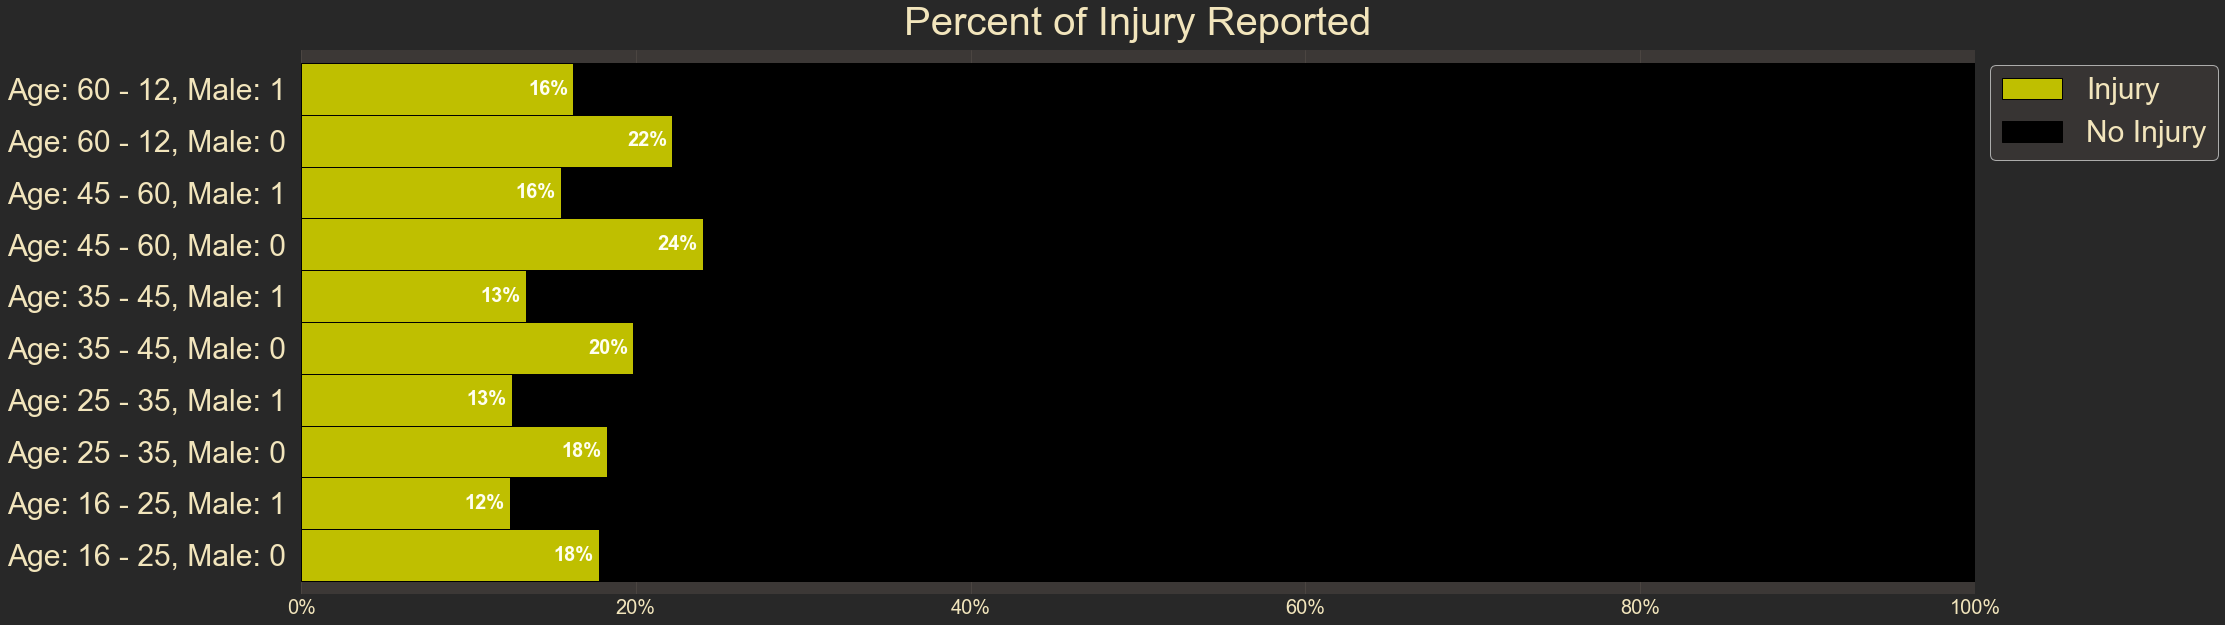

In [31]:
# set ax
fig, ax = plt.subplots(figsize=(30,10))
# create barplot
bars = injury_pct_df.plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:10]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\(\((\d{2}),\s(\d{2}).+(\d).+', r'Age: \1 - \2, Male: \3', str(x)) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury Reported', fontsize=40, pad=15)
# make it rain
plt.show()

In [32]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['factors_road', 'damage_zone']).crash_id.count() /
                    train.groupby(['factors_road', 'damage_zone']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['factors_road', 'damage_zone']).crash_id.count() /
                    train.groupby(['factors_road', 'damage_zone']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

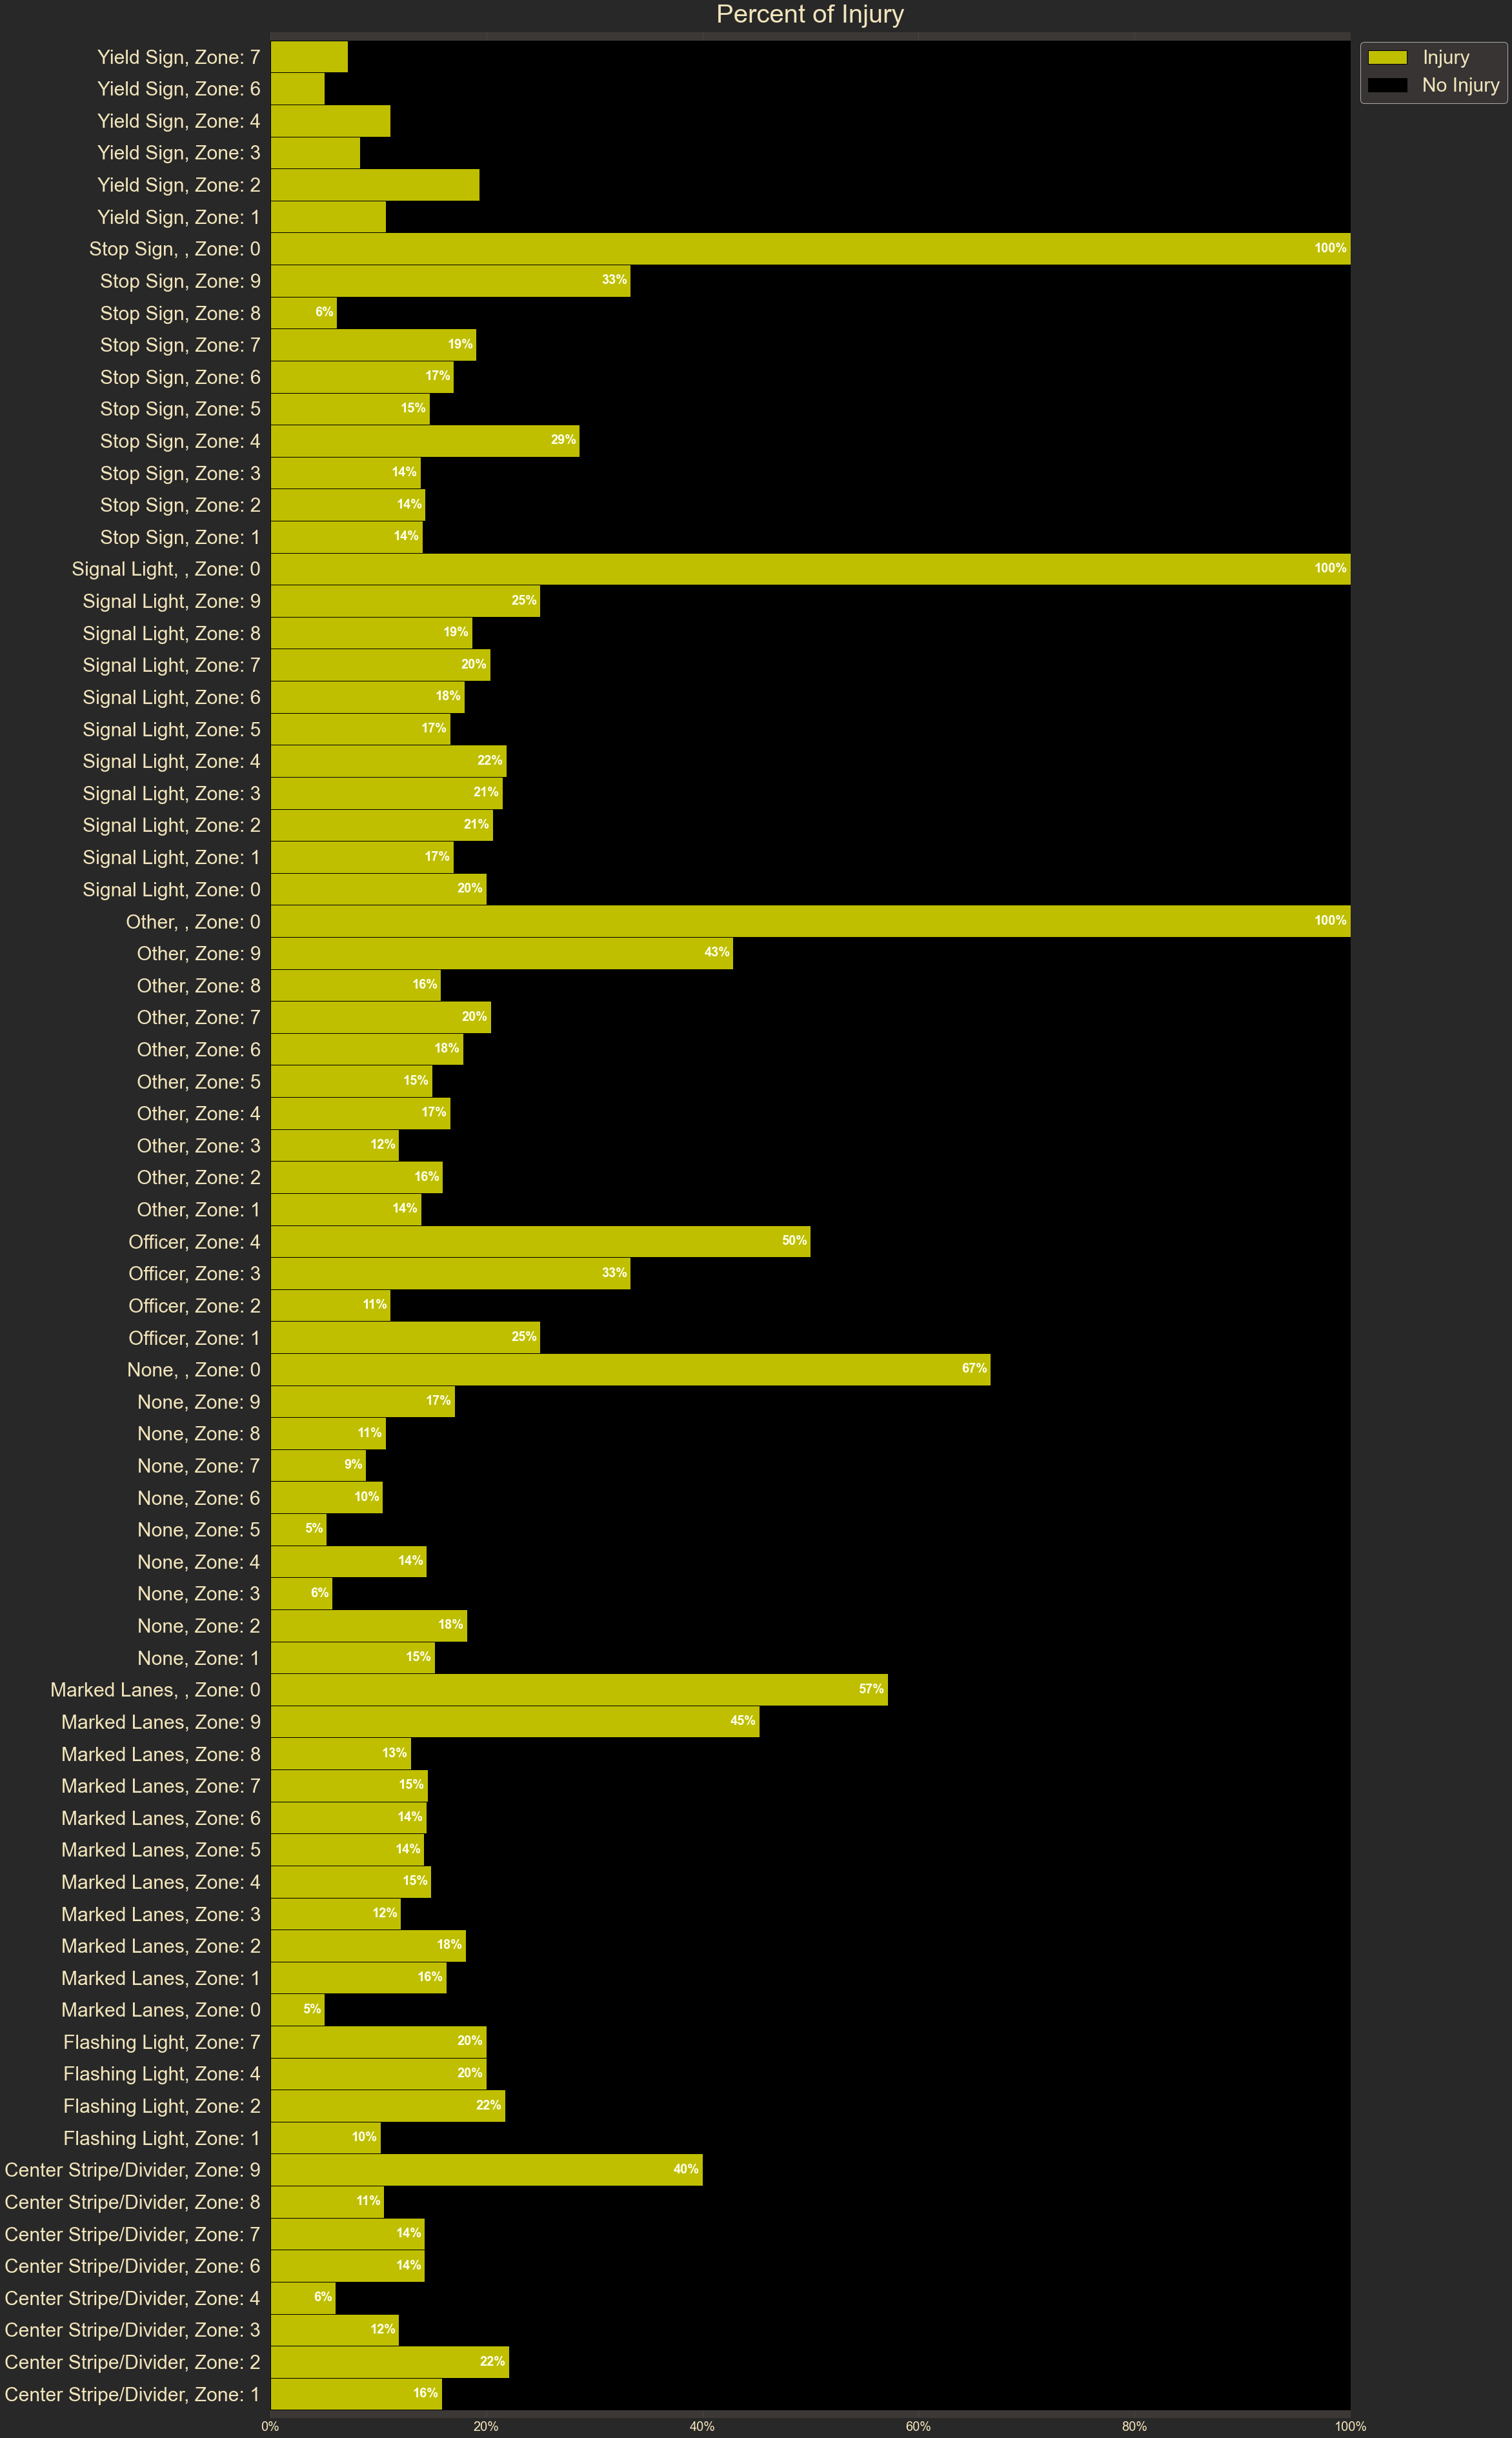

In [33]:
# set ax
fig, ax = plt.subplots(figsize=(30,68))
# create barplot
bars = injury_pct_df[injury_pct_df.pct_inj > 0].plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:68]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\((.+[^,]).+(\d{1,2}).+', r'\1, Zone: \2', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

In [34]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['damage_airbag', 'damage_zone']).crash_id.count() /
                    train.groupby(['damage_airbag', 'damage_zone']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['damage_airbag', 'damage_zone']).crash_id.count() /
                    train.groupby(['damage_airbag', 'damage_zone']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

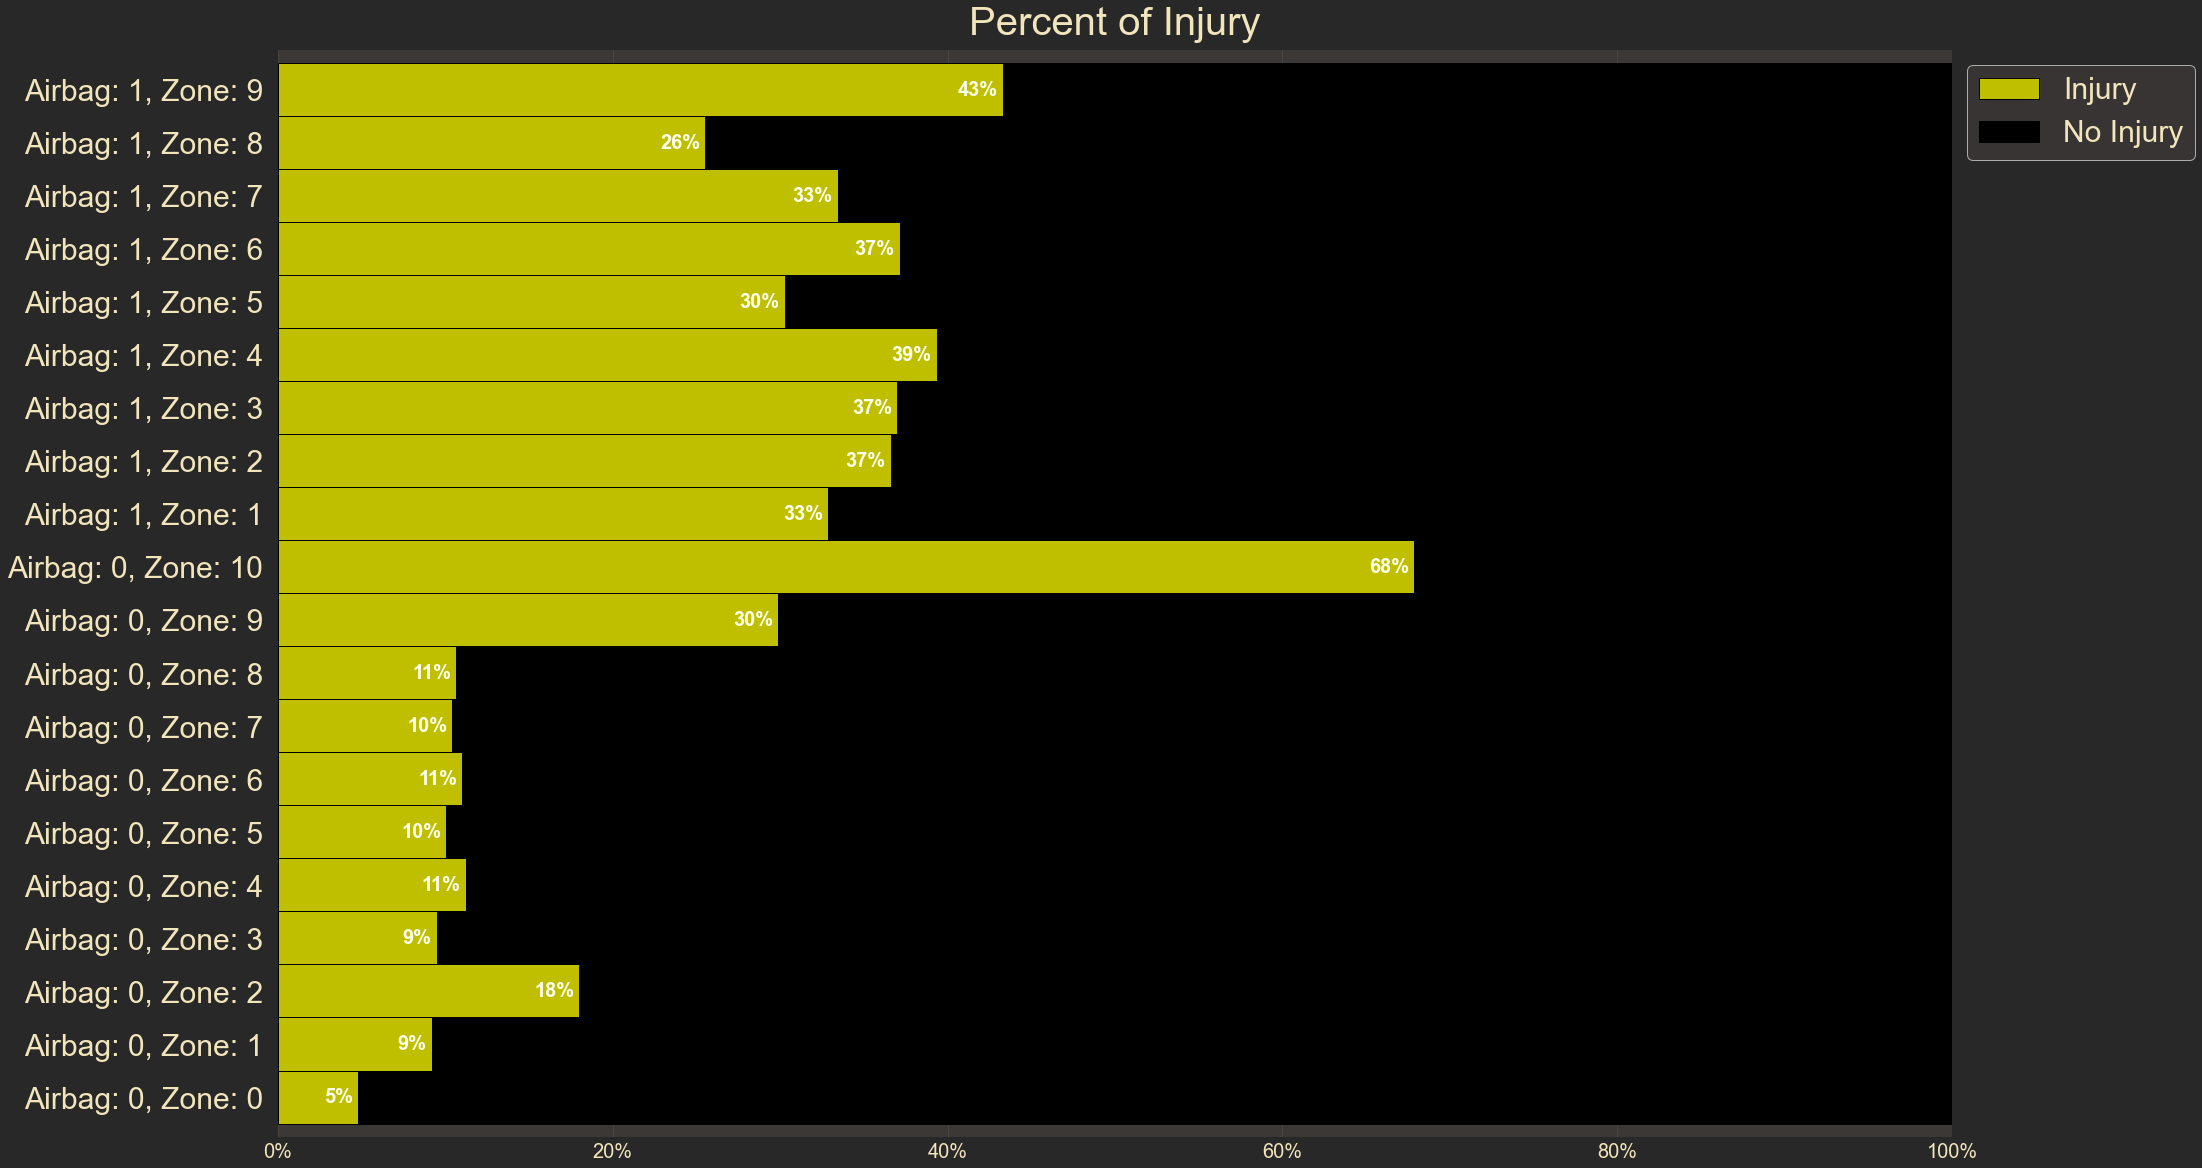

In [35]:
# set ax
fig, ax = plt.subplots(figsize=(30,20))
# create barplot
bars = injury_pct_df[injury_pct_df.pct_inj > 0].plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:20]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.set_yticklabels([re.sub(r'.+\'\((\d)\D+(\d+).+', r'Airbag: \1, Zone: \2', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

In [36]:
# create pct_inj column for injury pct
pct_inj = (train[train.injury_class == 1].groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count() /
                    train.groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count())
# create pct_not column for not injured pct
pct_not = (train[train.injury_class == 0].groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count() /
                    train.groupby(['vehicle_year_bin', 'damage_zone']).crash_id.count())
# create DataFrame of injury percentages
injury_pct_df = pd.concat((pct_inj, pct_not), axis=1)
injury_pct_df.columns = ['pct_inj', 'pct_not']

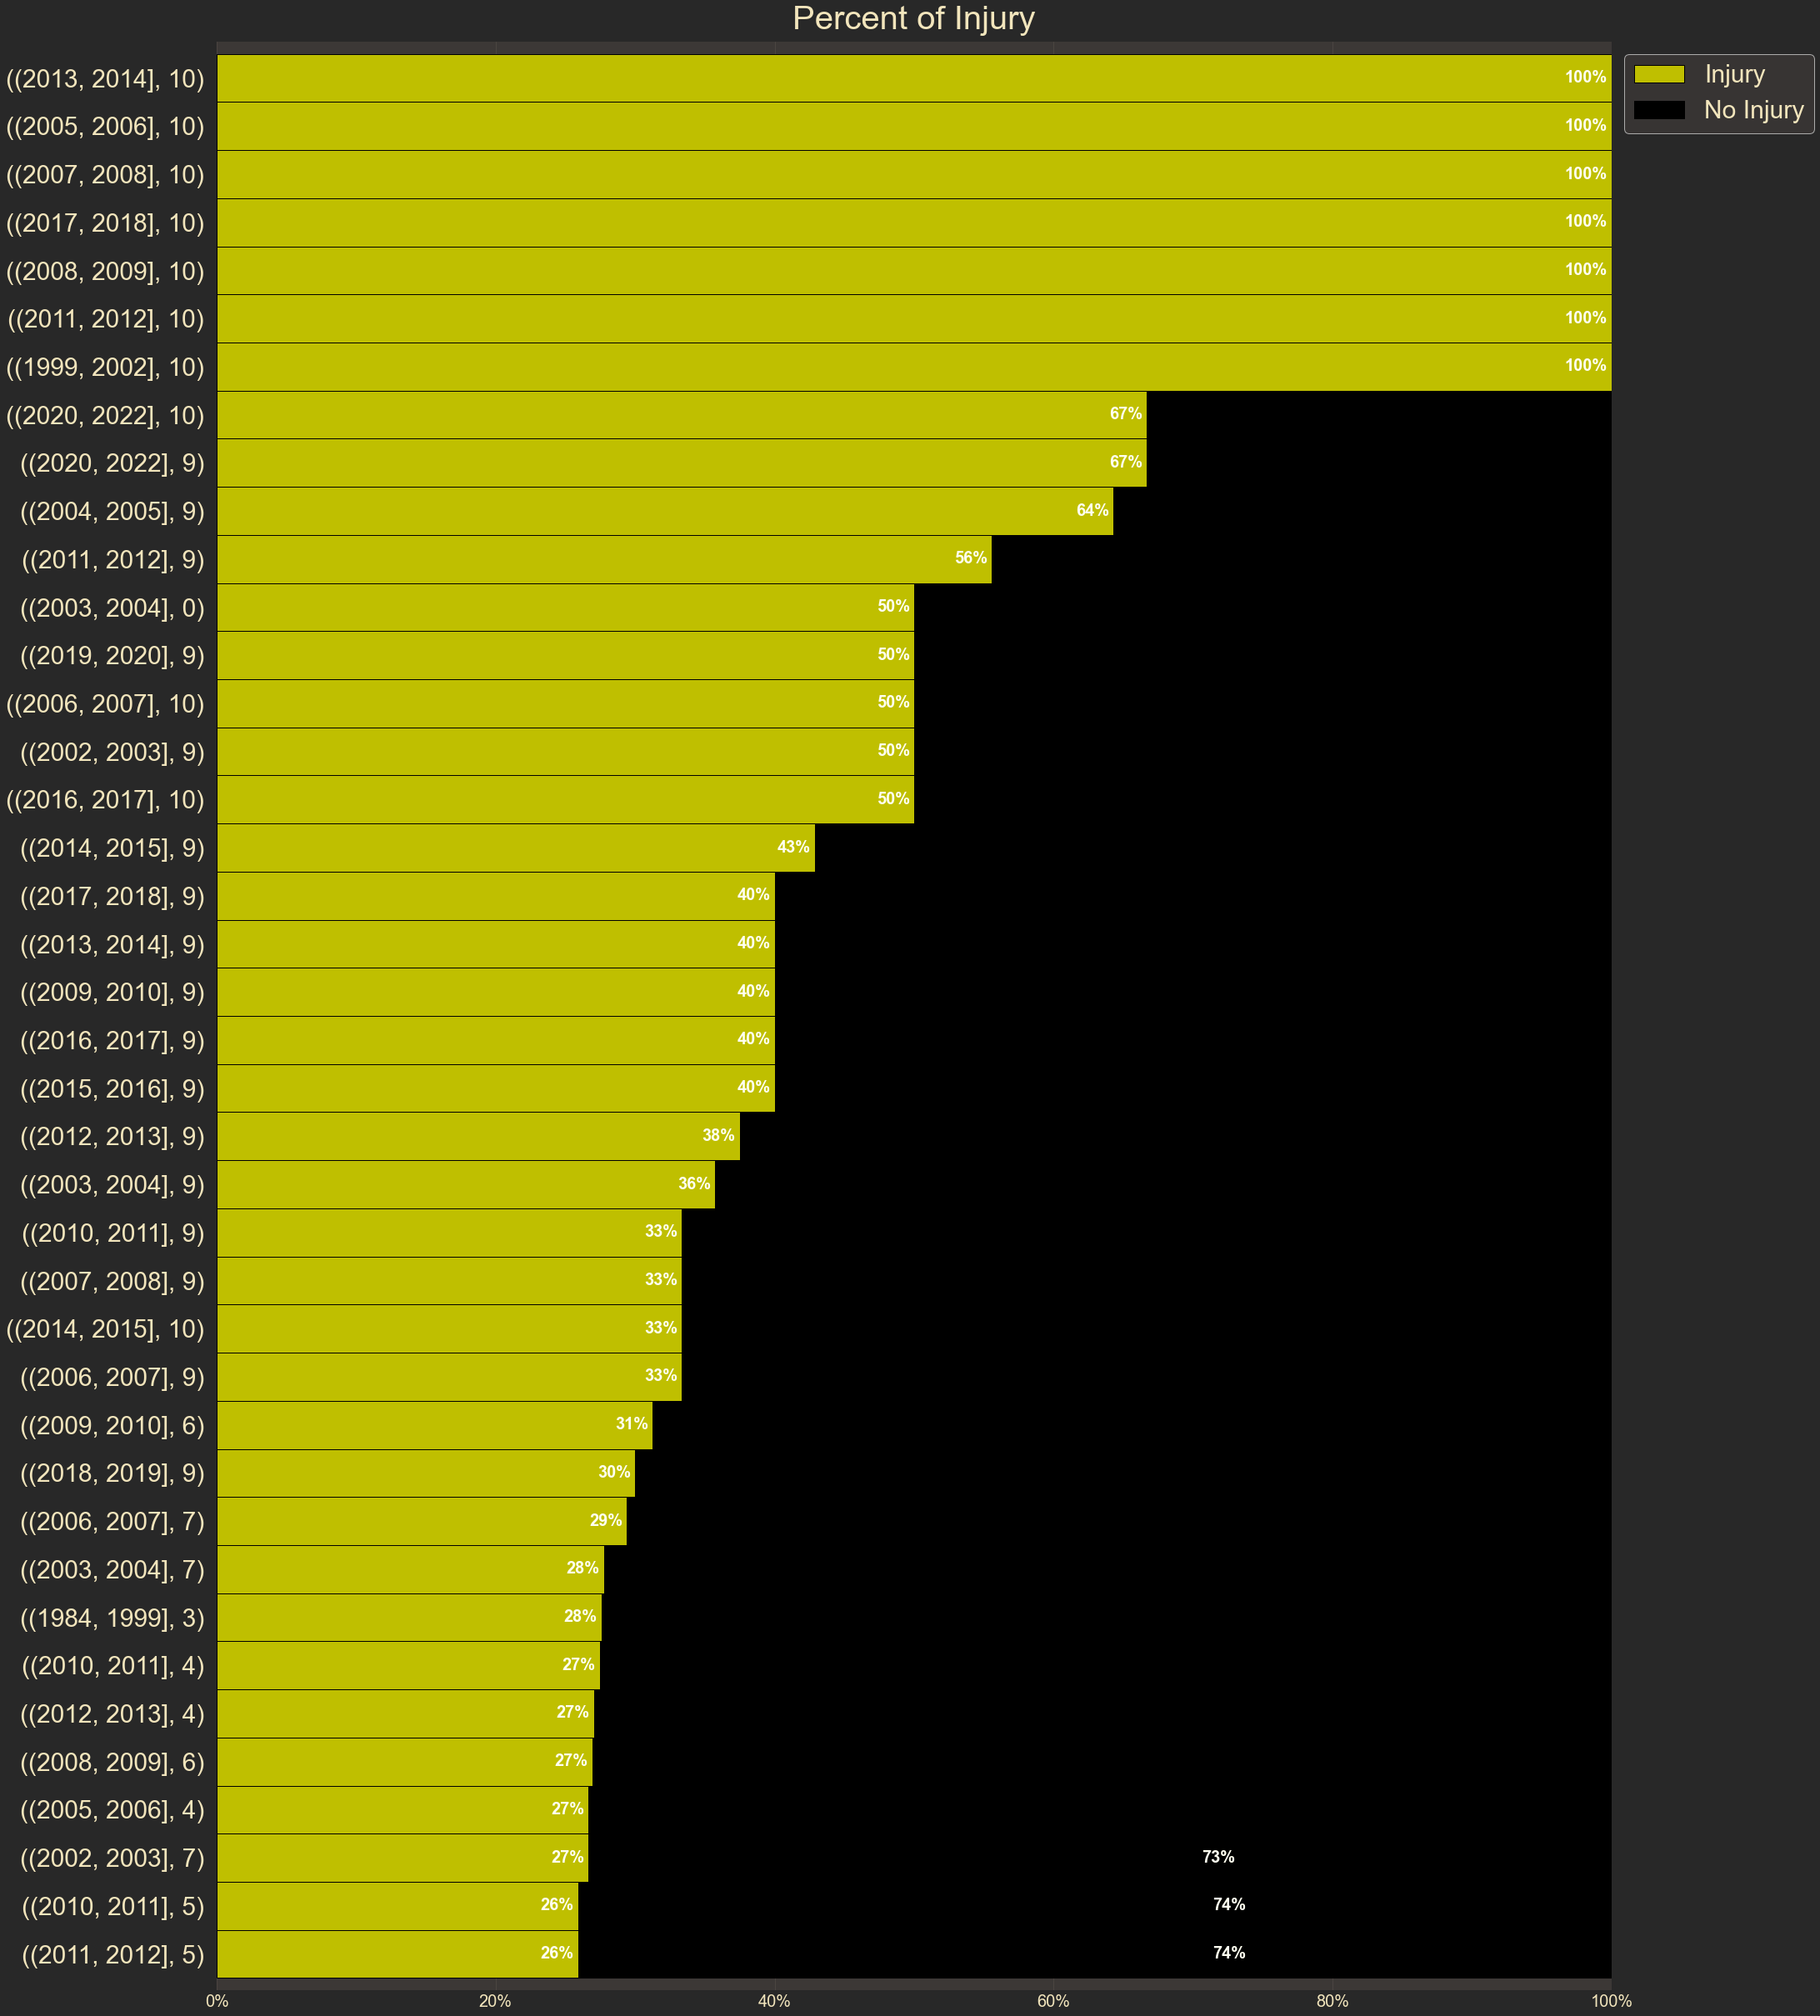

In [37]:
# set ax
fig, ax = plt.subplots(figsize=(30, 43))
# create barplot
bars = injury_pct_df[injury_pct_df.pct_inj > 0.25].sort_values('pct_inj').plot.barh(width=1,
                                ec='k',
                                stacked=True,
                                ax=ax,
                                color=['y', 'k'])
for bar in bars.patches[:43]:
    # add annotation for percentage at end of bar
    plt.annotate(format(bar.get_width(), '.0%'),
                 (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                 ha='right',
                 va='center',
                 xytext = (-5, 0),
                 textcoords='offset points',
                 fontsize=20,
                 weight='bold',
                 color='ivory')
# set tick parameters
ax.tick_params(axis='y', labelsize=30, pad=15)
ax.tick_params(axis='x', labelsize=20, pad=5)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
# ax.set_yticklabels([re.sub(r'.+\'\((\d)\D+(\d+).+', r'Airbag: \1, Zone: \2', str(x).title()) for x in ax.get_yticklabels()])
# limit xaxis to 1
ax.set_xlim(xmax=1)
# remove unneeded lavel
ax.set_ylabel('')
# define legend
ax.legend(labels=['Injury', 'No Injury'],
          bbox_to_anchor=(1,1), fontsize=30, frameon=True)
# set a title
plt.title('Percent of Injury', fontsize=40, pad=15)
# make it rain
plt.show()

## Modeling

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

#### Split Data

In [4]:
# split train data to X, y
X_train = train.select_dtypes(np.number).drop(columns=['injury_class', 'injury_crash_total'])
y_train = train.injury_class

In [5]:
# split test data to X, y
X_test = test.select_dtypes(np.number).drop(columns=['injury_class', 'injury_crash_total'])
y_test = test.injury_class

#### Baseline Creation

In [6]:
# create dummy class object
dummy = DummyClassifier(strategy='most_frequent')
# fit dummy for most frequent target class
dummy.fit(X_train, y_train)
# create baseline array
baseline = pd.Series(dummy.predict(X_train), index=X_train.index)

#### Resample Data for Class Balance

In [7]:
# create smote object
sm = SMOTE(random_state=19)
# fit and resample train data
X_sm, y_sm = sm.fit_resample(X_train, y_train)

#### Scaling Data

In [8]:
# create scaler object
scaler = StandardScaler()
# fit scaler to train
scaler.fit(X_train)

StandardScaler()

In [9]:
# scale X_test data
X_sm = pd.DataFrame(scaler.transform(X_sm), columns=X_sm.columns, index=X_sm.index)
# scale X_test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

#### Create Classifiers

In [10]:
# set dict of params for gridsearch
params = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
'dual':[True, False],
'class_weight':[None, 'balanced'],
'random_state':[19],
'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
'multi_class':['auto', 'ovr', 'multinomial']}
# perform gridsearch for best hyperparamters to recall
gridsearch(X_sm, y_sm, LogisticRegression(), params, scoring='recall')

class_weight   dual  multi_class penalty  random_state     solver  \
7           None   True         auto      l2            19  liblinear   
82          None  False          ovr      l1            19  liblinear   
202     balanced  False          ovr      l1            19  liblinear   
182     balanced  False         auto      l1            19  liblinear   
147     balanced   True          ovr      l2            19  liblinear   
27          None   True          ovr      l2            19  liblinear   
127     balanced   True         auto      l2            19  liblinear   
62          None  False         auto      l1            19  liblinear   
184     balanced  False         auto      l1            19       saga   
224     balanced  False  multinomial      l1            19       saga   

        score  
7    0.742816  
82   0.742816  
202  0.742816  
182  0.742816  
147  0.742816  
27   0.742816  
127  0.742816  
62   0.742816  
184  0.742760  
224  0.742760

In [20]:
# fit model to gridsearch params
logit = LogisticRegression(class_weight=None,
                           dual=True,
                           multi_class='auto',
                           penalty='l2',
                           random_state=19,
                           solver='liblinear')

In [21]:
# get top 20 RFE recommended features
rfe_selected = get_rfe_selected(X_sm, y_sm, logit).Feature.tolist()
# fit classifier with recommended features
logit.fit(X_sm[rfe_selected], y_sm)
# create array of predicitons
y_preds = logit.predict(X_sm[rfe_selected])

In [22]:
classifier_scores(y_sm, y_preds)


+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+
|            *** Model  Report ***            |
|            ---------------------            |
|---------------------------------------------|
|                 Accuracy:   74.99%          |
|                Precision:   74.26%          |
|                   Recall:   76.49%          |
|            Total Support:    35704          |
+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+



<br><br>
   
   

In [ ]:
extra_oversampled_data = df[df.injury == 1].sample(100)
pd.concat([df, extra_oversampled_data])

In [26]:
# set dict of params for gridsearch
params = {'n_neighbors':[5, 10, 15, 20, 25],
          'weights':['uniform', 'distance']}
# perform gridsearch for best hyperparamters to recall
gridsearch(X_sm, y_sm, KNeighborsClassifier(), params, scoring='recall')

n_neighbors   weights     score
1            5  distance  0.848130
3           10  distance  0.844488
5           15  distance  0.840119
7           20  distance  0.836590
9           25  distance  0.835413
0            5   uniform  0.827908
4           15   uniform  0.812559
8           25   uniform  0.807181
6           20   uniform  0.792505
2           10   uniform  0.786119

In [49]:
# use SelectKBest for recommended features
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_sm, y_sm)
kbest = SelectKBest()
kbest.fit(X_sm, y_sm)
kbest_selected = X_sm.columns[kbest.get_support()]

In [52]:
# fit model to gridsearch params
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [54]:
# fit classifier with recommended features
knn.fit(X_sm[kbest_selected], y_sm)
# create array of predicitons
y_preds = knn.predict(X_sm[kbest_selected])

In [55]:
classifier_scores(y_sm, y_preds)


+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+
|            *** Model  Report ***            |
|            ---------------------            |
|---------------------------------------------|
|                 Accuracy:   55.87%          |
|                Precision:   80.58%          |
|                   Recall:   15.48%          |
|            Total Support:    35704          |
+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+



<br><br>
   
   

In [ ]:
RandomForestClassifier()

In [59]:
# set dict of params for gridsearch
params = {'n_estimators':[100, 200],
          'criterion':['gini','entropy'],
          'max_depth':[2, 5, 10],
          'min_samples_split':[1, 2, 3],
          'min_samples_leaf':[1, 2, 3],
          'max_leaf_nodes':[1, 5, None],
          'random_state':[19],
          'class_weight':['balanced', 'balanced_subsample']}
# perform gridsearch for best hyperparamters to recall
gridsearch(X_sm, y_sm, RandomForestClassifier(), params, scoring='recall')

class_weight criterion  max_depth  max_leaf_nodes  \
472  balanced_subsample      gini         10             NaN   
470  balanced_subsample      gini         10             NaN   
634  balanced_subsample   entropy         10             NaN   
473  balanced_subsample      gini         10             NaN   
146            balanced      gini         10             NaN   
148            balanced      gini         10             NaN   
309            balanced   entropy         10             NaN   
147            balanced      gini         10             NaN   
154            balanced      gini         10             NaN   
152            balanced      gini         10             NaN   

     min_samples_leaf  min_samples_split  n_estimators  random_state     score  
472                 1                  3           100            19  0.776033  
470                 1                  2           100            19  0.775417  
634                 1                  3           100            19  0.774856  
473                 1                  3           200            19  0.774688  
146                 1                  2           100            19  0.773680  
148                 1                  3           100            19  0.773456  
309                 1                  2           200            19  0.773456  
147                 1                  2           200            19  0.773400  
154                 2                  3           100            19  0.773344  
152                 2                  2           100            19  0.773344

In [61]:
forest = RandomForestClassifier(class_weight='balanced_subsample',
                                criterion='gini',
                                max_depth=10,
                                min_samples_leaf=1,
                                n_estimators=100,
                                random_state=19)

In [62]:
# get top 20 RFE recommended features
rfe_selected = get_rfe_selected(X_sm, y_sm, forest).Feature.tolist()
# fit classifier with recommended features
forest.fit(X_sm[rfe_selected], y_sm)
# create array of predicitons
y_preds = forest.predict(X_train[rfe_selected])

In [63]:
classifier_scores(y_sm, y_preds)


+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+
|            *** Model  Report ***            |
|            ---------------------            |
|---------------------------------------------|
|                 Accuracy:   85.02%          |
|                Precision:   86.43%          |
|                   Recall:   83.09%          |
|            Total Support:    35704          |
+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+



In [65]:
y_preds = forest.predict(X_test_scaled[rfe_selected])
classifier_scores(y_test, y_preds)


+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+
|            *** Model  Report ***            |
|            ---------------------            |
|---------------------------------------------|
|                 Accuracy:   76.68%          |
|                Precision:   30.79%          |
|                   Recall:   34.33%          |
|            Total Support:     5334          |
+~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~+



In [67]:
SMOTE

crash_hour  crash_id  crash_latitude  crash_longitude  \
0        1.413386  1.241892        0.802096         1.105777   
1       -0.383101  0.635174       -0.424809         0.142245   
2        0.515143 -1.522631        1.550870        -0.828666   
3       -1.999939  0.209482        0.290986        -0.154726   
4       -2.179588 -0.385842       -0.228807         0.215611   
...           ...       ...             ...              ...   
35699   -1.281344 -0.477004       -0.241034        -0.059199   
35700    0.874440 -0.478923        0.175834         0.175992   
35701    0.874440  0.669284       -0.662970        -0.352844   
35702   -0.742398 -1.143920       -0.647102         0.864463   
35703    0.874440 -0.689683        1.644338         0.150587   

       crash_occupant_count  crash_vehicle_count  damage_air  damage_airbag  \
0                 -0.508864            -0.199940   -0.755040      -0.495587   
1                  0.099890            -0.199940   -0.755040      -0.495587   
2                 -1.117617            -1.494213   -0.755040      -0.495587   
3                  1.317396             1.094333   -0.755040      -0.495587   
4                  0.099890            -0.199940    0.991913      -0.495587   
...                     ...                  ...         ...            ...   
35699             -0.508864            -0.199940    0.118437      -0.495587   
35700             -1.117617            -1.494213   -0.755040      -0.495587   
35701              0.708643            -0.199940    0.118437      -0.495587   
35702             -0.508864            -0.199940    0.991913      -0.495587   
35703              0.099890            -0.199940    0.991913      -0.495587   

       damage_burned  damage_concentrated  ...  fault_distraction  \
0          -0.023722            -0.356594  ...          -0.754357   
1          -0.023722            -0.356594  ...           1.325633   
2          -0.023722            -0.356594  ...          -0.754357   
3          -0.023722            -0.356594  ...          -0.754357   
4          -0.023722            -0.356594  ...           1.325633   
...              ...                  ...  ...                ...   
35699      -0.023722            -0.356594  ...          -0.754357   
35700      -0.023722            -0.356594  ...          -0.754357   
35701      -0.023722            -0.356594  ...          -0.754357   
35702      -0.023722            -0.356594  ...          -0.754357   
35703      -0.023722             2.804309  ...          -0.754357   

       fault_fatigue  fault_intoxication  fault_maneuver  fault_speed  \
0          -0.169373           -0.179779        1.232601     2.433676   
1          -0.169373           -0.179779       -0.811292    -0.410901   
2          -0.169373           -0.179779        1.232601    -0.410901   
3          -0.169373           -0.179779        1.232601    -0.410901   
4          -0.169373            5.562384       -0.811292    -0.410901   
...              ...                 ...             ...          ...   
35699      -0.169373           -0.179779        1.232601    -0.410901   
35700      -0.169373           -0.179779       -0.811292    -0.410901   
35701      -0.169373           -0.179779       -0.811292    -0.410901   
35702      -0.169373           -0.179779       -0.811292    -0.410901   
35703      -0.169373           -0.179779       -0.811292    -0.410901   

       fault_yield  speed_speed_lm  speed_yield_occu  vehicle_occupant_count  \
0        -0.169373       -0.654894          0.582758               -0.430993   
1        -0.169373       -0.654894         -0.577105               -0.430993   
2        -0.169373       -0.654894          0.582758               -0.430993   
3        -0.169373        2.180883         -0.577105               -0.430993   
4        -0.169373        2.180883         -0.577105                0.806480   
...            ...             ...               ...                     ...   
35699    -0.169373     

In [68]:
rfe_selected

['vehicle_year',
 'crash_id',
 'crash_latitude',
 'crash_longitude',
 'fault_maneuver',
 'crash_vehicle_count',
 'damage_air',
 'damage_airbag',
 'fault_distraction',
 'damage_concentrated',
 'damage_distributed',
 'fault_class',
 'damage_zone',
 'factors_spd_lmt_mph',
 'driver_male',
 'driver_age',
 'crash_hour',
 'speed_speed_lm',
 'fault_speed',
 'crash_occupant_count']